In [1]:
#TARGIL No. 1 
# By Sahar Goelman
# selected database: rasturants.csv
#TODO: add link to the resource

In [1]:
%pylab inline
import os
from pyspark import SparkContext, SparkConf
import datetime


Populating the interactive namespace from numpy and matplotlib


In [2]:
## Validate that the database file exists otherwise break
if  not os.path.isfile("resturants.csv"):
    print("please add resturants.csv to :"+os.getcwd())

In [3]:
#question (1) loading the database
csv = sc.textFile("resturants.csv")

csv_header = csv.first() 
print("Column names:",format(csv_header))
csv_data = csv.filter(lambda line : line != csv_header) #remove csv headers from data
print("Number of rows loaded: {}".format(csv.count()))

Column names: business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category


Number of rows loaded: 53577


In [4]:
import matplotlib.pyplot as plt
import numpy as np
COL_NAMES = ['inspection_score', 'business_id','inspection_id','business_postal_code', 'business_phone_number']
COL_NAMES_INDEXES = {k: v for v, k in enumerate(COL_NAMES)}

x = csv_data.rdd.map(lambda x: (x.ID, list(x[1:])))
x.getNumPartitions()

split_headers= csv_header.split(",")
col_name = "inspection_score"
col_index=COL_NAMES_INDEXES[col_name]
rdd_mapped = x.map(lambda x: (x[1][col_index], 1))
rdd_reduced = rdd_mapped.reduceByKey(lambda x, y: x + y).map(lambda x: (x[1], x[0])).sortByKey(False).collect()


print("Number of distinct values in the", col_name, "column:", len(rdd_mapped.distinct().countByKey()))

fig = plt.figure(figsize=(15, 6))
amount, label = zip(*rdd_reduced)
plt.bar(label, amount)
plt.title(col_name + " column distribution")
plt.show()




AttributeError: 'PipelinedRDD' object has no attribute 'rdd'

In [6]:
#problem number (2):

#RDD is assumed to contain an (unique) index column at position 0
def get_RDD_row_by_index(rdd, index=0):
    nrows = rdd.count()
    if index < nrows:
        return rdd.filter(lambda kv: kv[0] == index)
    return None

#RDD is assumed to contain the requested col_nama
def get_RDD_col_values(rdd, col_name):
    col_index = fv.get_index_from_key(col_name)
    return rdd.map(lambda line: line[1][col_index])


#add a unique_id and split csv using commas
baseData = csv_data.zipWithIndex().map(lambda line: (line[-1],line[:-1][0].split(",")))
print("Added unique id at column 0:\nfirst=: {}".format(baseData.first()))
print("Added unique id at column 0:\nfirst[1]: {}".format(baseData.first()[1]))
print("Added unique id at column 0:\nfirst[1][1]: {}".format(baseData.first()[1][1]))
#test our method to get the n'th row from RDD
#print("take the {}th row from Data: {}".format(75, get_RDD_row_by_index(baseData,75).first()))
print('number of rows in dataBase: {}'.format(baseData.count()))


Added unique id at column 0:
first=: (0, ['39810', 'Cherry Blossom Bakery', '844 Clement St', 'San Francisco', 'CA', '94118', '37.782778', '-122.468341', '"{\'latitude\': \'37.782778\'', " 'needs_recoding': False", ' \'human_address\': \'{""address"":""""', '""city"":""""', '""state"":""""', '""zip"":""""}\'', ' \'longitude\': \'-122.468341\'}"', '', '39810_20160308', '2016-03-08T00:00:00', '77', 'Routine - Unscheduled', '39810_20160308_103124', 'Inadequately cleaned or sanitized food contact surfaces', 'Moderate Risk', '94119'])


Added unique id at column 0:
first[1]: ['39810', 'Cherry Blossom Bakery', '844 Clement St', 'San Francisco', 'CA', '94118', '37.782778', '-122.468341', '"{\'latitude\': \'37.782778\'', " 'needs_recoding': False", ' \'human_address\': \'{""address"":""""', '""city"":""""', '""state"":""""', '""zip"":""""}\'', ' \'longitude\': \'-122.468341\'}"', '', '39810_20160308', '2016-03-08T00:00:00', '77', 'Routine - Unscheduled', '39810_20160308_103124', 'Inadequately cleaned or sanitized food contact surfaces', 'Moderate Risk', '94119']


Added unique id at column 0:
first[1][1]: Cherry Blossom Bakery


number of rows in dataBase: 53576


In [7]:
#problem number (3.a): unique values of the 5 columns 
#RDD is assumed to contain the requested col_name
#row 0 is the first row
def get_RDD_col_value(rdd, row_index, col_name):
    print ("header indexes are:{}".format(fiveHeaders.get_all_values()))
    col_index = fiveHeaders.get_index_from_key(col_name)
    row = get_RDD_row_by_index(rdd, row_index)
    val  = row.first()[1][col_index]
    print ("rdd[{}][{}] = {}".format(row_index, col_index,val))
    #val = row[col_index]
    #print("value of {} at row {} = {}".format(col_name, row_index, val))
    #return val
    #print ("==>Col index of {} is {}".format(col_index, col_name))
    #return rdd.map(lambda line: line[1][col_index])
    #print(get_RDD_col_values(baseData,'business_name'))
    #for col_name in fv.get_index_from_key()
    #dictionary = {}
    #for col_index in fiveHeaders.get_all_values():
    #    baseData.map(lambda row: get_RDD_col_values(baseData, col_index))

get_RDD_col_value(baseData, 100, 'business_id')

header indexes are:[12, 0, 10, 5, 9]
rdd[100][1] = The Mayflower


In [7]:
import math
#alloows counting only numerical columns
class Data_Filter():
    def __init__(self, header_name):
        self.col_indexes = header_name.get_all_values()
        self.build_line = self._builder(self.list_creator)
        self.build_filter = self._builder(self.create_filter_is_num)
        
    def _builder(self, func):
        return func(self.col_indexes)

    def number(self, s):
        ret = None
        try:
            ret = int(s)
        except ValueError:
            ret = float(s)
        finally:
            return ret

    def is_not_number(self, s):
        ret = False
        try:
            #print("value = ".format(s))
            if (math.isnan(self.number(s))):  #not a number
                ret = True
        except:
            print("exception in is_not_number, s = {}".format(s))
            ret = True
        finally:
            return ret

    def list_creator(self, col_indexes):
        def get_unique_line(_line, unique_id, append_num=True):
            items = []
            for col in col_indexes:
                if append_num:
                    item = self.number(_line[col])
                else:
                    item = _line[col]
                items.append(item)
            return (unique_id, items)
        return get_unique_line


    def create_filter_is_num(self, col_indexes):

        def check_is_number(_line):
            ret = True
            for col in col_indexes:
                try:
                    #print ("_line = {}".format(_line))
                    #print ("value[{}]: {}".format(col, _line[col]))
                    if (math.isnan(self.number(_line[col]))):
                        ret = False
                except:
                    #TODO
                    print('create_filter_is_num caught an exception\n _line[{}]={}'.format(col, _line[col]))
                    ret = False
            return ret
        return check_is_number

print ("filtering data")
filtered_data = Data_Filter(fiveHeaders)
print(filtered_data)
print("end filtering data")

filtering data
end filtering data


In [8]:
i = 0
for col_name in headers: 
    print("index of col_names[{}] = {}".format(col_name,filtered_data.col_indexes[i]))
    i = i + 1
    
filteredByColumn = baseData.filter(lambda line: filtered_data.build_filter(line[1])).map(lambda line: filtered_data.build_line(line[1], line[0]))

def count_distinct(filter_by_column, headerName, key):
    res =  filter_by_column.map(lambda pair: pair[1][headerName.get_index_from_key(key)]).distinct().count()
    return res
def print_distinct(col_name):
        cnt = count_distinct(filteredByColumn, fiveHeaders, col_name)
        print('Distint values of col: {} = {}'.format(col_name, cnt))
        return cnt

index of col_names[inspection_score] = 12
index of col_names[business_id] = 0
index of col_names[inspection_id] = 10
index of col_names[business_postal_code] = 5
index of col_names[business_phone_number] = 9


In [9]:
#Question 3/a
col_distinct_counts = {}
for header in headers:
    res = print_distinct(header)
    col_distinct_counts[header] = res


Distint values of col: inspection_score = 41


Distint values of col: business_id = 836


Distint values of col: inspection_id = 1937


Distint values of col: business_postal_code = 32


Distint values of col: business_phone_number = 782


Histogram of column:inspection_score


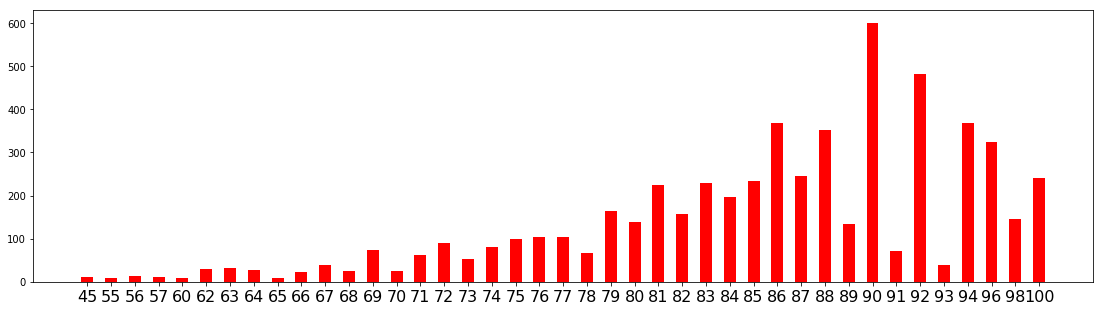

Histogram of column:business_id


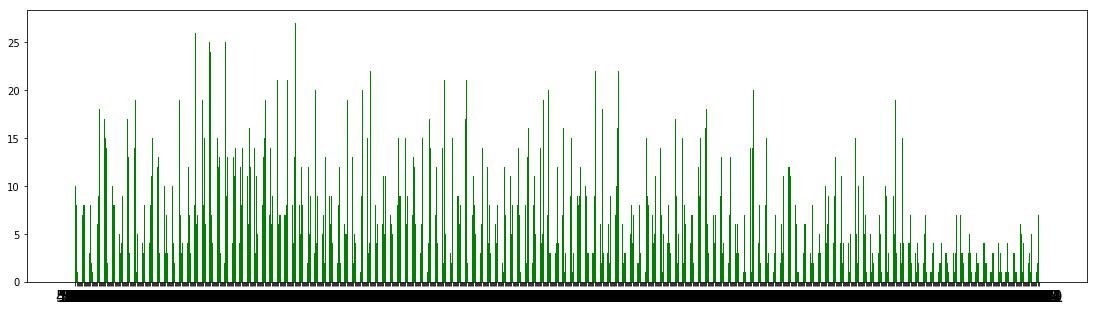

Histogram of column:inspection_id


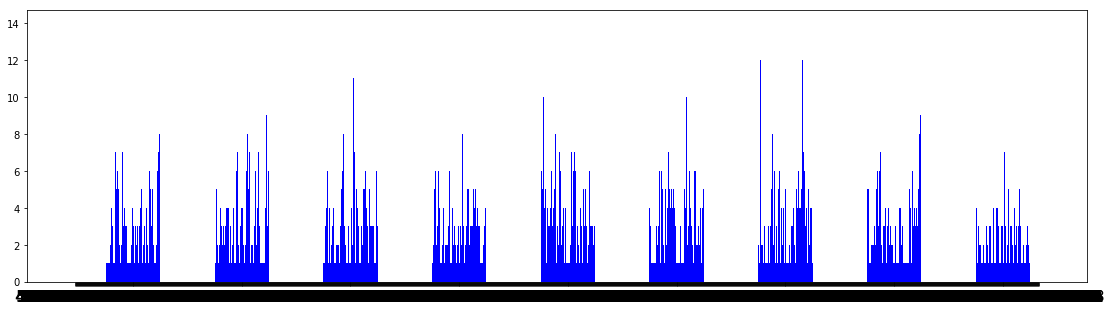

Histogram of column:business_postal_code


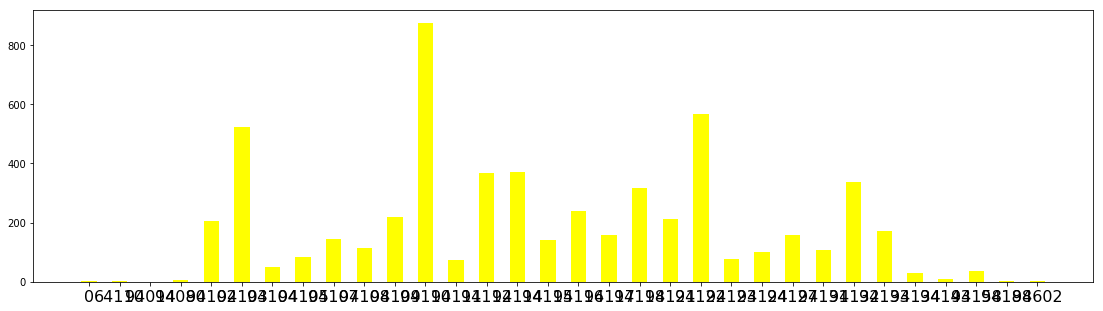

Histogram of column:business_phone_number


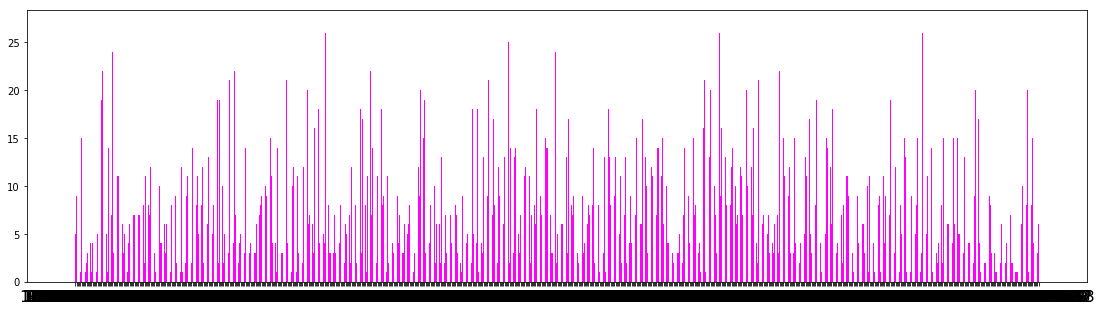

In [10]:
#Utility functions to plot histogram
class Histogram():

    def show(self, col_name, color):
        obj = self.countAggregateByKey(col_name)
        self.plot(obj,color)
    
    def countAggregateByKey(self, col_name):
        aggragateByKey = col_name.countByValue() 
        keys  = aggragateByKey.keys()
        x_axis = np.array(sorted(keys))
        y_axis = np.array([aggragateByKey.get(key) for key in x_axis])
        return self.buildObj(x_axis,y_axis)
    
    def buildObj(self, x_axis,y_axis):
        res = dict()
        res['x'] = {
            'pos': np.arange(len(x_axis)),
            'x_axis':x_axis
        }
        res['y']={
            'y_axis':y_axis
        }
        return res
    
    def plot(self, obj,color):
        y_axis = obj['y']['y_axis']
        pos = obj['x']['pos']
        x_axis = obj['x']['x_axis']

        ax = plt.axes()
        ax.set_xticks(pos)
        ax.set_xticklabels(x_axis)

        plt.bar(pos, y_axis, 0.5, color=color)
        plt.xticks(size=16)

        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(19, 5)
        plt.show()
    

#Question 3/b drawing histograms of the 5 columns
# get all indexes for a specific col name
# we normalize the "inpection_score" variable so that 
def filterColumnByHeader(filteredByColumn,col_names,key):
    return filteredByColumn.map(lambda pair: pair[1][col_names.get_index_from_key(key)])

histogram_colors = ['red', 'green', 'blue', 'yellow', 'magenta']
i = 0
h = Histogram()
for header in headers:
    data = filterColumnByHeader(filteredByColumn,fiveHeaders,header)#
    print ("Histogram of column:{}".format(header))
    h.show(data, histogram_colors[i])
    i = i + 1


In [19]:
##############################################################################################
#Utility functions 
##############################################################################################

In [11]:
class DataRecoveryModel:
    def __init__(self,v,sigma,median):
        items = dict()
        items['normal'] = {'mu':v[0]/v[1],'sigma':sigma }
        items['median'] = median
        self.items = items
    def getByType(self,_type):
        return self.items[_type]

In [13]:
class DataRecoveryService():
    def __init__(self, baseData, _fiveHeaders):
        self.fiveHeaders = _fiveHeaders
        self.items = dict()
        #hd = self.hd = Data_Filter(fiveHeaders)
        hd = self.hd = Data_Filter(_fiveHeaders)
        self.shrinkTableAndDarity = baseData.map(lambda line: hd.build_line(line[1], line[0], False))
        self.filteredByColumn = baseData.filter(lambda line: hd.build_filter(line[1])).map(
            lambda line: hd.build_line(line[1], line[0]))

    def fixByType(self, typeFixer, cloumnName):
        dataRecoveryModel = self.items[cloumnName]
        if typeFixer == 'mean':
            metadata = dataRecoveryModel.getByType('normal')
            return metadata['mu']
        elif typeFixer == 'median':
            return dataRecoveryModel.getByType('median')
        else:
            return 0


    def findTheMidle(self, NumOfVal):
        if NumOfVal % 2 != 0:
            NumOfVal = NumOfVal + 1
        return NumOfVal / 2

    def calcDataRecoveryTypes(self, columnName):
        hd = self.hd
        fv = self.fiveHeaders
        v = self.filteredByColumn.map(lambda pair: (pair[1][fv.get_index_from_key(columnName)], 1)).reduce(
            lambda a, b: (a[0] + b[0], a[1] + b[1]))
        n = self.findTheMidle(v[1])
        median = self.filteredByColumn.map(lambda pair: (pair[1][fv.get_index_from_key(columnName)])) \
            .sortBy(lambda item: item).zipWithIndex().filter(lambda pair: pair[1] == n).collect()[0][0]
        self.items[columnName] = DataRecoveryModel(v, 1, median)

    def normelizeColumn(self, cloumnName, sigma):
        fv = self.fiveHeaders
        dataRecoveryModel = self.items[cloumnName]
        metadata = dataRecoveryModel.getByType('normal')
        mu = metadata['mu']
        return self.filteredByColumn.map(
          lambda pair: normalizeFixer(pair[1][fv.get_index_from_key(cloumnName)], mu, sigma))
    
    def fixCellsByType(self, typeFixer, columnName):
        fv = self.fiveHeaders
        hd = self.hd
        fixedValue = self.fixByType(typeFixer, columnName)
        return self.shrinkTableAndDarity.map(
                lambda pair: fixCellsByTypePrivate(pair[1][fv.get_index_from_key(columnName)], fixedValue, hd))

def normalizeFixer(x, mu, sigma):
    return (x - mu)/sigma    
    
def fixCellsByTypePrivate(cell,fixedValue,hd):
    isNotANumber = True
    isNotANumber = hd.is_not_number(cell)
    if isNotANumber :
        cell = fixedValue
    else: 
        cell = hd.num(cell)
    return cell
        

In [14]:
fv = FiveHeaders()
fv.add_headers('business_id', 0)
print(fv.get_all_values())

#DRService = DataRecoveryService(baseData, fiveHeaders)
DRService = DataRecoveryService(baseData, fv)

hs = Histogram()
i = 0
for col_name in ['business_id']: #headers:
    DRService.calcDataRecoveryTypes(col_name)
    print("Histogram of column:{}".format(col_name))
    hs.show(DRService.fixCellsByType('mean', col_name), histogram_colors[i])
    i = i + 1



[0]


Histogram of column:business_id


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 29.0 failed 1 times, most recent failure: Lost task 1.0 in stage 29.0 (TID 53, localhost, executor driver): java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:213)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:223)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:440)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:249)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1992)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:172)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1661)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1649)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1648)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1648)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1882)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1820)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:165)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor43.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:213)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:223)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:223)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:440)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:249)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1992)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:172)
